<a href="https://www.kaggle.com/code/parisammm/glove-bilstm-self-attention?scriptVersionId=158746959" target="_blank"><img align="left" alt="Kaggle" title="Open in Kaggle" src="https://kaggle.com/static/images/open-in-kaggle.svg"></a>

In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/glove-embeddings/glove.6B.50d.txt
/kaggle/input/nlp-getting-started/sample_submission.csv
/kaggle/input/nlp-getting-started/train.csv
/kaggle/input/nlp-getting-started/test.csv


In [2]:
from torch.utils.data import Dataset, DataLoader, RandomSampler, SequentialSampler

In [3]:
pip install contractions

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 101.8/101.8 kB 5.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 289.9/289.9 kB 15.2 MB/s eta 0:00:00
Note: you may need to restart the kernel to use updated packages.


In [4]:
import matplotlib.pyplot as plt
import re
import contractions
import time
import string
from nltk.corpus import stopwords
from nltk.util import  ngrams, bigrams, trigrams
from wordcloud import WordCloud
from collections import Counter
import seaborn as sns
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.model_selection import train_test_split
from sklearn import metrics
from torch.utils.data import DataLoader
from keras.preprocessing.text import Tokenizer
from keras.utils import pad_sequences
from tqdm import tqdm, trange

In [7]:
import tensorflow as tf
from keras import Model
from keras.models import Sequential
from keras.initializers import Constant
from keras.layers import (LSTM,Bidirectional,Embedding,BatchNormalization,SpatialDropout1D,Dense,Dropout,
                         GRU, Input, Concatenate, Attention, Reshape, Layer)

from keras.optimizers import Adam
import keras.backend as K


In [10]:
glove_embedding= open('/kaggle/input/glove-embeddings/glove.6B.50d.txt')

In [11]:
def build_glove_embedding(glove_dir):
    with open(glove_dir, 'r', encoding='UTF-8') as f:
        word_dic={}
        for line in f:
            word= line.split()
            cur_word= word[0]
            word_dic[cur_word]= np.array(word[1:], dtype= 'float64')
    return word_dic
            

In [13]:
pretrained_embed= build_glove_embedding('/kaggle/input/glove-embeddings/glove.6B.50d.txt')

In [14]:
training_set = pd.read_csv('/kaggle/input/nlp-getting-started/train.csv', encoding='utf8')

In [15]:
training_set.head(20)

,id,keyword,location,text,target
0,1,NaN,NaN,Our Deeds are the Reason of this #earthquake M...,1
1,4,NaN,NaN,Forest fire near La Ronge Sask. Canada,1
2,5,NaN,NaN,All residents asked to 'shelter in place' are ...,1
3,6,NaN,NaN,"13,000 people receive #wildfires evacuation or...",1
4,7,NaN,NaN,Just got sent this photo from Ruby #Alaska as ...,1
5,8,NaN,NaN,#RockyFire Update => California Hwy. 20 closed...,1
6,10,NaN,NaN,#flood #disaster Heavy rain causes flash flood...,1
7,13,NaN,NaN,I'm on top of the hill and I can see a fire in...,1
8,14,NaN,NaN,There's an emergency evacuation happening now ...,1
9,15,NaN,NaN,I'm afraid that the tornado is coming to our a...,1


In [16]:
testing_set = pd.read_csv('/kaggle/input/nlp-getting-started/test.csv', encoding='utf8')

In [17]:
training_set['text'][0]

'Our Deeds are the Reason of this #earthquake May ALLAH Forgive us all'

# **Cleaning Data**

> delete unused columns from df

In [18]:
training_set = training_set.drop(columns=['keyword','location'])
testing_set = testing_set.drop(columns=['keyword','location'])

In [19]:
training_set.isnull().sum()

id        0
text      0
target    0
dtype: int64

In [20]:
testing_set.isnull().sum()

id      0
text    0
dtype: int64

In [21]:
for i, text in enumerate (training_set['text'][40:60]):
    print("text %d: \n "%(i+1), text)

text 1: 
  Check these out: http://t.co/rOI2NSmEJJ http://t.co/3Tj8ZjiN21 http://t.co/YDUiXEfIpE http://t.co/LxTjc87KLS #nsfw
text 2: 
  on the outside you're ablaze and alive
but you're dead inside
text 3: 
  Had an awesome time visiting the CFC head office the ancop site and ablaze. Thanks to Tita Vida for taking care of us ??
text 4: 
  SOOOO PUMPED FOR ABLAZE ???? @southridgelife
text 5: 
  I wanted to set Chicago ablaze with my preaching... But not my hotel! http://t.co/o9qknbfOFX
text 6: 
  I gained 3 followers in the last week. You? Know your stats and grow with http://t.co/TIyUliF5c6
text 7: 
  How the West was burned: Thousands of wildfires ablaze in California alone http://t.co/vl5TBR3wbr
text 8: 
  Building the perfect tracklist to life leave the streets ablaze
text 9: 
  Check these out: http://t.co/rOI2NSmEJJ http://t.co/3Tj8ZjiN21 http://t.co/YDUiXEfIpE http://t.co/LxTjc87KLS #nsfw
text 10: 
  First night with retainers in. It's quite weird. Better get used to it; I have 

In [22]:
def clean_text(text):
    
#     remove urls because there are lots of tweeter links
    URI_removed = re.sub(r'http\S+', "", text)
    
#     expand contractions to model sees  'i'm' and 'i am' the same
    Expanded_contractions = ' '.join([contractions.fix(i) for i in URI_removed.split()])
    LowerCase = Expanded_contractions.lower()
    
#     remove punctuations and digits and stopwords can be useful because they don't important information in this task
    Removed_punctuations= re.sub('[%s]' % re.escape(string.punctuation),' ',LowerCase)
    Removed_digits = re.sub(r'[0-9]','', Removed_punctuations)
    pattern = re.compile(r'\b(' + r'|'.join(stopwords.words('english')) + r')\b\s*')
    removed_stopw= pattern.sub(' ', Removed_digits)
    
    cleaned_text = ' '.join((re.sub("[^a-z]", ' ', removed_stopw, 0, re.IGNORECASE)).split())
    
    return cleaned_text
    

In [23]:
training_set['CleanedData']= training_set['text'].apply(lambda x: clean_text(x))
testing_set['CleanedData']= testing_set['text'].apply(lambda x: clean_text(x))

In [24]:
testing_set

,id,text,CleanedData
0,0,Just happened a terrible car crash,happened terrible car crash
1,2,"Heard about #earthquake is different cities, s...",heard earthquake different cities stay safe ev...
2,3,"there is a forest fire at spot pond, geese are...",forest fire spot pond geese fleeing across str...
3,9,Apocalypse lighting. #Spokane #wildfires,apocalypse lighting spokane wildfires
4,11,Typhoon Soudelor kills 28 in China and Taiwan,typhoon soudelor kills china taiwan
...,...,...,...
3258,10861,EARTHQUAKE SAFETY LOS ANGELES ÛÒ SAFETY FASTE...,earthquake safety los angeles safety fasteners...
3259,10865,Storm in RI worse than last hurricane. My city...,storm ri worse last hurricane city amp others ...
3260,10868,Green Line derailment in Chicago http://t.co/U...,green line derailment chicago
3261,10874,MEG issues Hazardous Weather Outlook (HWO) htt...,meg issues hazardous weather outlook hwo


In [25]:
for i, text in enumerate (training_set['CleanedData'][40:60]):
    print("text %d: \n "%(i+1), text)

text 1: 
  check nsfw
text 2: 
  outside ablaze alive dead inside
text 3: 
  awesome time visiting cfc head office ancop site ablaze thanks tita vida taking care us
text 4: 
  soooo pumped ablaze southridgelife
text 5: 
  wanted set chicago ablaze preaching hotel
text 6: 
  gained followers last week know stats grow
text 7: 
  west burned thousands wildfires ablaze california alone
text 8: 
  building perfect tracklist life leave streets ablaze
text 9: 
  check nsfw
text 10: 
  first night retainers quite weird better get used wear every single night next year least
text 11: 
  deputies man shot brighton home set ablaze
text 12: 
  man wife get six years jail setting ablaze niece
text 13: 
  santa cruz head st elizabeth police superintendent lanford salmon r
text 14: 
  police arsonist deliberately set black church north carolina ablaze
text 15: 
  noches el bestia alexis sanchez happy see teammates training hard goodnight gunners
text 16: 
  kurds trampling turkmen flag later set abla

# A few analyze on Dataset

> Checking the balance of classes

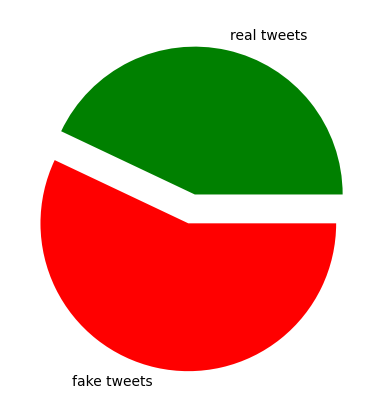

In [26]:
y = np.array([training_set['target'].value_counts()[1], training_set['target'].value_counts()[0]])
labels = ['real tweets', 'fake tweets']
myexplode= [0,0.2]
mycolor = ['green', 'red']
plt.pie(y, labels=labels, explode= myexplode, colors=mycolor)
plt.show()

> visualizing most frequent words after cleaning data using wordcloud

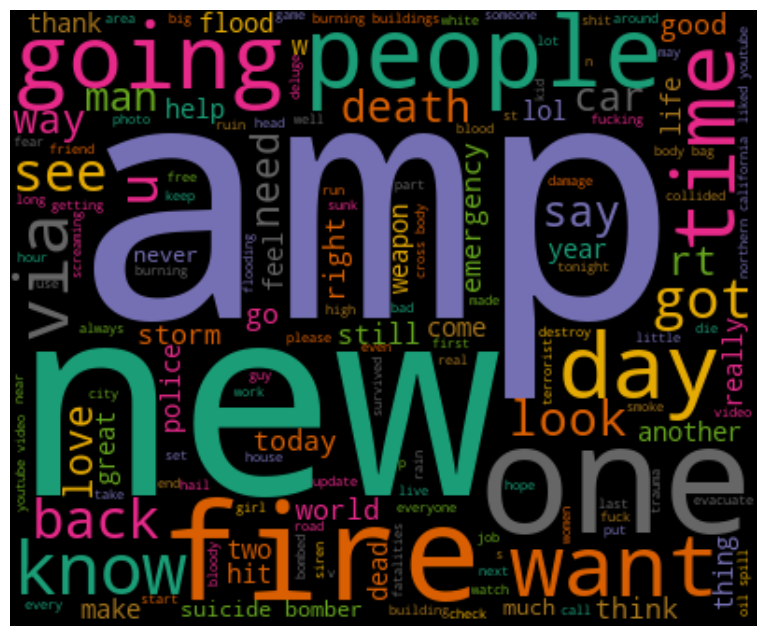

In [27]:
Wcloud = WordCloud(width=400, height=330, colormap='Dark2', background_color='black' ,max_words=150).generate(" ".join(i for i in training_set.CleanedData))
plt.figure(figsize=(10,8))
plt.imshow(Wcloud, interpolation='bilinear')
plt.axis('off')
plt.show()


> check length of each sentence 

<AxesSubplot:>

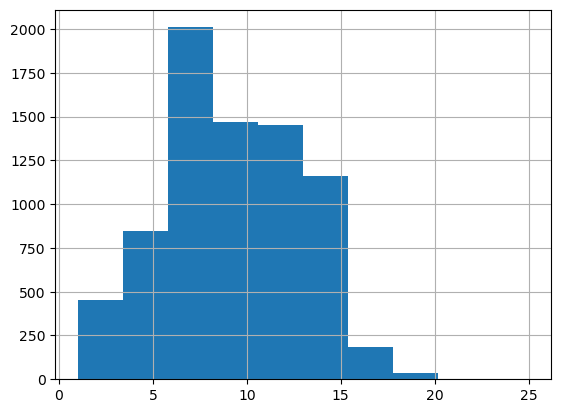

In [28]:
training_set['CleanedData'].str.split().map(lambda x: len(x)).hist()

<AxesSubplot:>

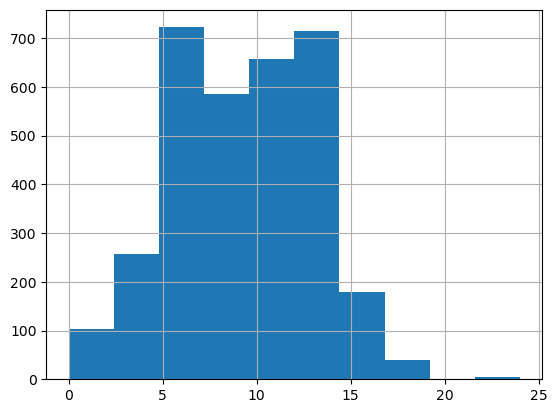

In [29]:
testing_set['CleanedData'].str.split().map(lambda x: len(x)).hist()

In [30]:
training_set['text_list']= training_set.CleanedData.str.split()

In [31]:
corpus=[]
for i in range (training_set.shape[0]):
    corpus.extend(training_set['text_list'][i])
    

In [32]:
len(Counter(corpus))

16068

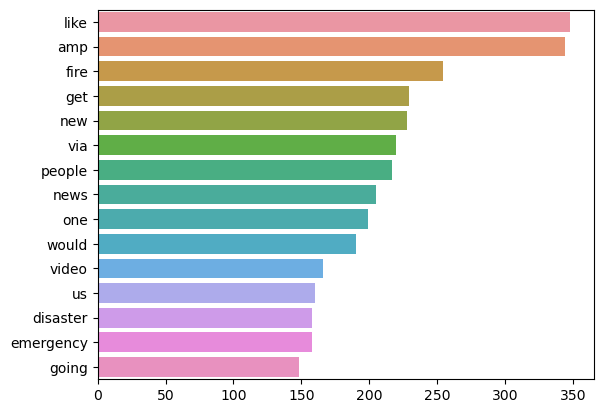

In [33]:
most_commonwords= Counter(corpus).most_common(15)
most_commonwords
word=[]
freq=[]
for w,c in most_commonwords:
    word.append(w)
    freq.append(c)
sns.barplot(x=freq, y=word)
plt.show()

> Exploration most frequent bigrams to get better underestanding of used words

In [34]:
vec= CountVectorizer(ngram_range=(2,2))
bigrams= vec.fit_transform(training_set['CleanedData'])

In [35]:
bigrams_freq= [(word,bigrams.sum(axis=0)[0,i]) for word , i in (vec.vocabulary_.items())]
bigrams_freq= sorted(bigrams_freq, key= lambda x:x[1], reverse=True)[:20]

In [36]:
bigrams_freq

[('burning buildings', 59),
 ('suicide bomber', 59),
 ('youtube video', 43),
 ('liked youtube', 42),
 ('northern california', 41),
 ('cross body', 40),
 ('oil spill', 39),
 ('suicide bombing', 36),
 ('let us', 36),
 ('california wildfire', 34),
 ('year old', 34),
 ('looks like', 33),
 ('mass murder', 32),
 ('heat wave', 31),
 ('gt gt', 31),
 ('full read', 31),
 ('natural disaster', 31),
 ('mass murderer', 31),
 ('prebreak best', 30),
 ('bomber detonated', 30)]

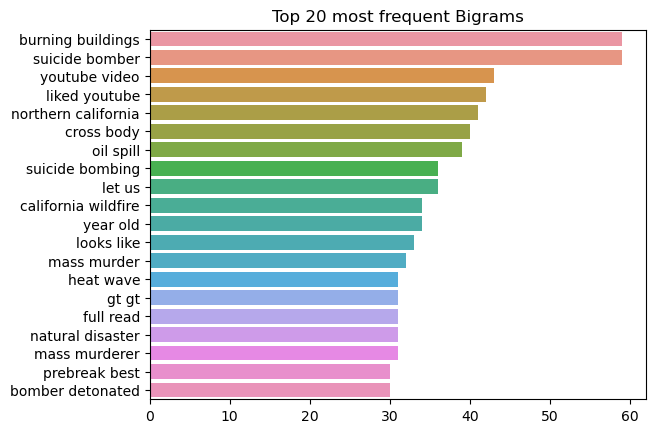

In [37]:
y= list(list(zip(*bigrams_freq))[0])
x= list(list(zip(*bigrams_freq))[1])
sns.barplot(x=x, y=y)
plt.title("Top 20 most frequent Bigrams")
plt.show()

# **Preprocess and padding and indexing data to feed into model**

In [38]:
def PrepareData (text, max_len):
    
#     t= Tokenizer(num_words=50000, oov_token='<oov>')
    t= Tokenizer(num_words=5000, oov_token='<oov>')
    t.fit_on_texts(text)
    word_to_index= t.word_index
    x_seq = t.texts_to_sequences(text)
    x_padded = pad_sequences(x_seq, maxlen=max_len, padding='post', truncating='post')
    
    return x_padded, word_to_index


In [40]:
MAX_LEN= 30
embed_vector_len= 50
batch_train_size= 128
batch_eval_size= 64
embed_dim1=64
embed_dim2=32
num_class=1
hidden_dim=32
vocab_size= len(Counter(corpus)) +2
epochs=100
seed = 0

In [41]:
set_train, word_to_index = PrepareData(training_set['CleanedData'], MAX_LEN)

In [42]:
len(word_to_index)

16069

In [43]:
emb_matrix= np.zeros((vocab_size, embed_vector_len))

for word, index in word_to_index.items():
    embed_vector= pretrained_embed.get(word)
    if embed_vector is not None:
        emb_matrix[index,:]= embed_vector
    

In [47]:
x_test,_ = PrepareData(testing_set['CleanedData'], MAX_LEN)

In [45]:
training_set

,id,text,target,CleanedData,text_list
0,1,Our Deeds are the Reason of this #earthquake M...,1,deeds reason earthquake may allah forgive us,"[deeds, reason, earthquake, may, allah, forgiv..."
1,4,Forest fire near La Ronge Sask. Canada,1,forest fire near la ronge sask canada,"[forest, fire, near, la, ronge, sask, canada]"
2,5,All residents asked to 'shelter in place' are ...,1,residents asked shelter place notified officer...,"[residents, asked, shelter, place, notified, o..."
3,6,"13,000 people receive #wildfires evacuation or...",1,people receive wildfires evacuation orders cal...,"[people, receive, wildfires, evacuation, order..."
4,7,Just got sent this photo from Ruby #Alaska as ...,1,got sent photo ruby alaska smoke wildfires pou...,"[got, sent, photo, ruby, alaska, smoke, wildfi..."
...,...,...,...,...,...
7608,10869,Two giant cranes holding a bridge collapse int...,1,two giant cranes holding bridge collapse nearb...,"[two, giant, cranes, holding, bridge, collapse..."
7609,10870,@aria_ahrary @TheTawniest The out of control w...,1,aria ahrary thetawniest control wild fires cal...,"[aria, ahrary, thetawniest, control, wild, fir..."
7610,10871,M1.94 [01:04 UTC]?5km S of Volcano Hawaii. htt...,1,utc km volcano hawaii,"[utc, km, volcano, hawaii]"
7611,10872,Police investigating after an e-bike collided ...,1,police investigating e bike collided car littl...,"[police, investigating, e, bike, collided, car..."


In [31]:
# train_data1 = training_set.sample(frac= 0.8, random_state=200)
# eval_data1 = training_set.drop(train_data1.index).reset_index(drop=True)
# train_data1 = train_data1.reset_index(drop=True)

In [50]:
x_train, x_eval, y_train, y_eval= train_test_split(set_train,training_set['target'], test_size=0.2, train_size=0.8, 
                 random_state=42, stratify=training_set['target'] )

In [51]:
y_train.value_counts()

6234    1
326     0
997     0
7269    0
2189    1
       ..
3386    1
3280    1
305     0
1648    0
7569    0
Name: target, Length: 6090, dtype: int64

In [52]:
y_eval.value_counts()

0    869
1    654
Name: target, dtype: int64

In [53]:
x_train.shape, x_eval.shape, y_train.shape, y_eval.shape

((6090, 30), (1523, 30), (6090,), (1523,))

# **Building Model and Train**

In [57]:
import transformers

In [58]:
bert=transformers.BertModel.from_pretrained('bert-base-uncased')

Some weights of the model checkpoint at bert-base-uncased were not used when initializing BertModel: ['cls.seq_relationship.weight', 'cls.seq_relationship.bias', 'cls.predictions.decoder.weight', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.bias', 'cls.predictions.transform.dense.weight', 'cls.predictions.transform.dense.bias']
- This IS expected if you are initializing BertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


In [59]:
from transformers import BertTokenizer, BertModel, BertConfig

In [60]:
tokenizer = BertTokenizer.from_pretrained('bert-base-uncased')

In [62]:
class attention(Layer):
    def __init__(self,**kwargs):
        super(attention,self).__init__(**kwargs)
 
    def build(self,input_shape):
        self.W=self.add_weight(name='attention_weight', shape=(input_shape[-1],1), 
                               initializer='random_normal', trainable=True)
        self.b=self.add_weight(name='attention_bias', shape=(input_shape[1],1), 
                               initializer='zeros', trainable=True)        
        super(attention, self).build(input_shape)
 
    def call(self,x):
        # Alignment scores. Pass them through tanh function
        e = K.tanh(K.dot(x,self.W)+self.b)
        # Remove dimension of size 1
        e = K.squeeze(e, axis=-1)   
        # Compute the weights
        alpha = K.softmax(e)
        # Reshape to tensorFlow format
        alpha = K.expand_dims(alpha, axis=-1)
        # Compute the context vector
        context = x * alpha
        context = K.sum(context, axis=1)
        return context

In [63]:
def BiLSTM_with_attention(embed_dim1, embed_dim2, hidden_dim, num_class ,input_shape):
    
    tf.random.set_seed(123)
    x =Input(shape=input_shape)
    
    Embedding_Layer= Embedding(emb_matrix.shape[0], emb_matrix.shape[1],
                        weights=[emb_matrix], 
                        input_length=MAX_LEN, 
                        trainable=False)(x)
    
    Dropout_Layer1= SpatialDropout1D(0.2)(Embedding_Layer)
    
    LSTM_Layer1= Bidirectional(LSTM(embed_dim1, dropout=0.2, recurrent_dropout=0.2, return_sequences=True))(Dropout_Layer1)
    
    lstm, forward_h, forward_c, backward_h, backward_c= Bidirectional(LSTM(embed_dim2, dropout=0.2, recurrent_dropout=0.2, return_sequences=True ,return_state= True))(LSTM_Layer1)
    
#     state_h = Concatenate()([forward_h, backward_h])
#     state_h_reshape= Reshape((1, 2*embed_dim2), input_shape=(2*embed_dim2,))(state_h)
    
#     attention_Layer= Attention(dropout=0.1, trainable=True)([state_h_reshape, lstm])
    attention_Layer= attention()(lstm)



    
#     attention_reshape= Reshape((2*embed_dim2,), input_shape=(1,2*embed_dim2))(attention_Layer)
#     print(attention_reshape.shape)
    output= Dense(hidden_dim, activation='relu')(attention_Layer)
    output= Dense(num_class, activation='sigmoid')(output)
    
    model= Model(x, output)
    
    optimzer=Adam(learning_rate=1e-3)

    model.compile(optimizer= optimzer, 
                  loss='binary_crossentropy',
                  metrics=['acc'])
    return model


In [64]:
LstmAttention_model= BiLSTM_with_attention(embed_dim1, embed_dim2, hidden_dim, num_class ,(MAX_LEN,))

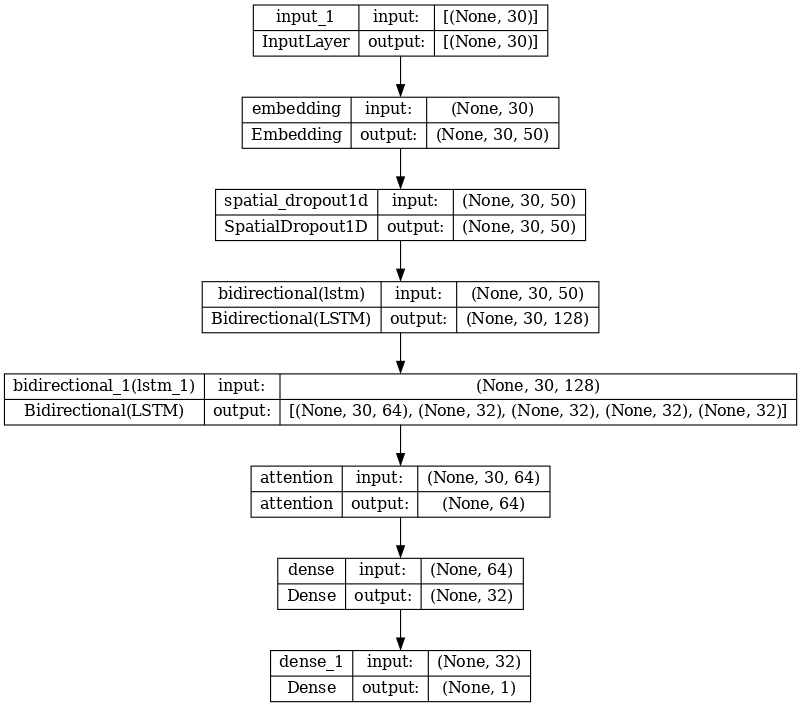

In [65]:
tf.keras.utils.plot_model(LstmAttention_model, show_shapes=True, dpi=80)

In [66]:
LstmAttention_model.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 30)]              0         
                                                                 
 embedding (Embedding)       (None, 30, 50)            803500    
                                                                 
 spatial_dropout1d (SpatialD  (None, 30, 50)           0         
 ropout1D)                                                       
                                                                 
 bidirectional (Bidirectiona  (None, 30, 128)          58880     
 l)                                                              
                                                                 
 bidirectional_1 (Bidirectio  [(None, 30, 64),         41216     
 nal)                         (None, 32),                        
                              (None, 32),                    

In [67]:
early_stop= tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=5)

In [68]:
history = LstmAttention_model.fit(x_train,y_train, 
                batch_size=batch_train_size, 
                epochs=epochs, 
                validation_data=(x_eval, y_eval), 
                shuffle=True, callbacks=[early_stop])

Epoch 1/100
48/48 [==============================] - 34s 454ms/step - loss: 0.5615 - acc: 0.7369 - val_loss: 0.4514 - val_acc: 0.7905
Epoch 2/100
48/48 [==============================] - 21s 431ms/step - loss: 0.4862 - acc: 0.7811 - val_loss: 0.4531 - val_acc: 0.8011
Epoch 3/100
48/48 [==============================] - 21s 436ms/step - loss: 0.4742 - acc: 0.7833 - val_loss: 0.4311 - val_acc: 0.8070
Epoch 4/100
48/48 [==============================] - 21s 430ms/step - loss: 0.4788 - acc: 0.7788 - val_loss: 0.4521 - val_acc: 0.8017
Epoch 5/100
48/48 [==============================] - 21s 438ms/step - loss: 0.4653 - acc: 0.7874 - val_loss: 0.4232 - val_acc: 0.8076
Epoch 6/100
48/48 [==============================] - 21s 436ms/step - loss: 0.4592 - acc: 0.7890 - val_loss: 0.4202 - val_acc: 0.8070
Epoch 7/100
48/48 [==============================] - 21s 429ms/step - loss: 0.4554 - acc: 0.7906 - val_loss: 0.4204 - val_acc: 0.8083
Epoch 8/100
48/48 [==============================] - 21s 434ms

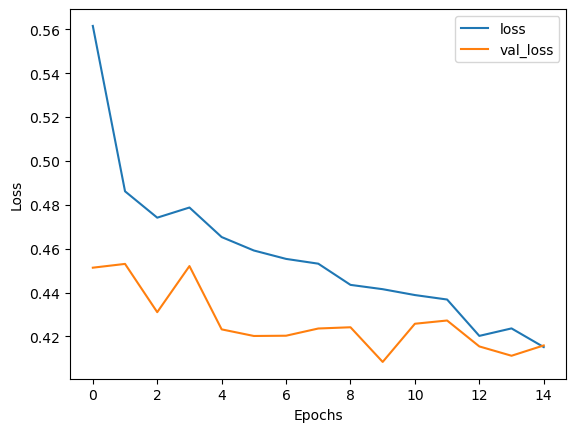

In [69]:
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend(['loss','val_loss'])
plt.show()

In [70]:
preds = LstmAttention_model.predict(x_test, batch_size=64)

51/51 [==============================] - 3s 33ms/step


In [71]:
preds

array([[0.22723591],
       [0.21779762],
       [0.8051095 ],
       ...,
       [0.19677766],
       [0.9434731 ],
       [0.17946751]], dtype=float32)

In [73]:
preds

array([[0.16201375],
       [0.19775967],
       [0.69732666],
       ...,
       [0.16813315],
       [0.96377933],
       [0.07328733]], dtype=float32)

In [72]:
preds.shape

(3263, 1)

In [74]:
preds = preds.round().astype(int).reshape(3263) 

In [76]:
submission_df= pd.DataFrame({'id':testing_set.id, 'target': preds})

In [77]:
submission_df

,id,target
0,0,0
1,2,0
2,3,1
3,9,0
4,11,0
...,...,...
3258,10861,0
3259,10865,1
3260,10868,0
3261,10874,1


In [79]:
submission_df.to_csv('submission.csv',index=False)